In [1]:
import os
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ToTensord,
    Resized,
    AsChannelLastd,
    AsChannelFirstd,
    AsDiscrete,
    CropForeground,
    SpatialCropd,
    AsDiscreted,
    ScaleIntensityRanged,
    LabelToContour
)
from monai.transforms.transform import MapTransform
from monai.transforms.inverse import InvertibleTransform
from monai.data import decollate_batch
import SimpleITK as sitk

import itk

from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union
import numpy as np

from monai.visualize import matshow3d, blend_images
import torch
import cv2
import imageio
from collections import Counter
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient, expand_labels)
from skimage.morphology import disk, dilation, binary_dilation, ball, cube, closing , disk


No audio backend is available.


### Minimizar

In [2]:
class RemoveDicts(MapTransform, InvertibleTransform):
    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            self.push_transform(d, key)

        a = {}
        for key in self.key_iterator(d):
            a[key] = d[key]
            if key == "image":
                a["path"] = d["image_meta_dict"]["filename_or_obj"]
        if a.get("path", None) is None:
            a["path"] = d["label_meta_dict"]["filename_or_obj"]

        # a = {"image": d["image"], "label": d["label"], "label-gc":  d["label-gc"] , "path": d["image_meta_dict"]["filename_or_obj"]}

        # print(a["path"])
        d = a
        return d

    def inverse(self, data: Mapping[Hashable, Any]) -> Dict[Hashable, Any]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            d[key] = d[key]
            # Remove the applied transform
            self.pop_transform(d, key)
        return d


In [3]:
from monai.transforms.intensity.array import ScaleIntensityRangePercentiles


class ScaleIntensityRangePercentilesd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.ScaleIntensityRangePercentiles`.

    Args:
        keys: keys of the corresponding items to be transformed.
            See also: monai.transforms.MapTransform
        lower: lower percentile.
        upper: upper percentile.
        b_min: intensity target range min.
        b_max: intensity target range max.
        clip: whether to perform clip after scaling.
        relative: whether to scale to the corresponding percentiles of [b_min, b_max]
        channel_wise: if True, compute intensity percentile and normalize every channel separately.
            default to False.
        dtype: output data type, if None, same as input image. defaults to float32.
        allow_missing_keys: don't raise exception if key is missing.
    """

    backend = ScaleIntensityRangePercentiles.backend

    def __init__(
        self,
        keys: KeysCollection,
        lower: float,
        upper: float,
        b_min: Optional[float],
        b_max: Optional[float],
        clip: bool = False,
        relative: bool = False,
        channel_wise: bool = False,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.scaler = ScaleIntensityRangePercentiles(
            lower, upper, b_min, b_max, clip, relative, channel_wise, dtype
        )

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.scaler(d[key])
        return d


In [4]:
class NNUnetScaleIntensity(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.ScaleIntensityRange`.

    Args:
        keys: keys of the corresponding items to be transformed.
            See also: monai.transforms.MapTransform
        a_min: intensity original range min.
        a_max: intensity original range max.
        b_min: intensity target range min.
        b_max: intensity target range max.
        clip: whether to perform clip after scaling.
        dtype: output data type, if None, same as input image. defaults to float32.
        allow_missing_keys: don't raise exception if key is missing.
    """

    def _compute_stats(self, volume, mask):
        print(volume.shape)
        print(mask.shape)
        volume = np.ma.masked_equal(volume.copy().astype(np.int16) * np.greater(mask, 0), 0).compressed()
        median = np.median(volume)
        mean = np.mean(volume)
        std = np.std(volume)
        mn = np.min(volume)
        mx = np.max(volume)
        percentile_99_5 = np.percentile(volume, 99.5)
        percentile_00_5 = np.percentile(volume, 00.5)
        print(median, mean, std, mn, mx, percentile_99_5, percentile_00_5)
        return median, mean, std, mn, mx, percentile_99_5, percentile_00_5

    def __init__(
        self,
        keys: KeysCollection,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            stats = self._compute_stats(d[key], d["label"])
            d[key] = np.clip(d[key], stats[6], stats[5])
            d[key] = (d[key] - stats[1]) / stats[2]
        return d


In [5]:
class WriteToMHA(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        output_dir: str,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.output_dir = output_dir

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            if isinstance(d[key], torch.Tensor):
                d[key] = d[key].detach().cpu().numpy().astype(np.int8)
            original = sitk.ReadImage(d["path"])
            filename = os.path.basename(d["path"]).split(".")[0] + ".mha"
            save_dir = os.path.join(self.output_dir, filename)
            if not os.path.exists(os.path.dirname(save_dir)):
                print(f"Creating directory: {os.path.dirname(save_dir)}")
                os.makedirs(os.path.dirname(save_dir))
            print(f"Saving to {save_dir}")
            img = sitk.GetImageFromArray(d[key])
            img.SetSpacing(original.GetSpacing())
            img.SetOrigin(original.GetOrigin())
            sitk.WriteImage(img, save_dir)

        return d


In [6]:
import cv2


class CreateSyntheticLabel(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        threshold: float = 0.5,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.threshold = threshold

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        print(d["label"].shape) # (1, 6, 512, 512, 199)
        d["label"] = d["label"].squeeze() # (6, 512, 512, 199))
        old_mask = d["label"][3, :, :, :].unsqueeze(0).numpy().copy() # (1, 512, 512, 199)
        # histogram, bin_edges = np.histogram(old_mask.flatten(), bins=256, range=(0, 1))

        # # configure and draw the histogram figure
        # plt.figure()
        # plt.title("Grayscale Histogram")
        # plt.xlabel("grayscale value")
        # plt.ylabel("pixel count")
        # plt.xlim([0.0, 1.0])  # <- named arguments do not work here

        # plt.plot(bin_edges[0:-1], histogram)  # <- or here
        # plt.show()
        new_mask = np.zeros_like(old_mask) # (1, 512, 512, 199)
        new_img = d["image"][:, :, :, :].numpy().copy()
        idx_label = np.where(old_mask.flatten() == 1)[0]
        idx_img = np.where(new_img.flatten() > self.threshold)[0]
        idx_to_change = np.intersect1d(idx_img, idx_label)
        np.put(new_mask, idx_to_change, 1)
        old_mask -= new_mask

        kernel = np.ones((3, 3), np.uint8)
        closed_slices = list()
        for slice in range(new_mask.shape[-1]):
            result = cv2.morphologyEx(
                new_mask[0, :, :, slice], cv2.MORPH_CLOSE, kernel, iterations=4
            )
            result = cv2.medianBlur(result, 9)
            closed_slices.append(result)

        new_mask = np.stack(closed_slices)

        if len (new_mask.shape) > 3: 
            new_mask = torch.Tensor(new_mask[0])
            old_mask = torch.Tensor(old_mask[0])
        else:
            new_mask = torch.Tensor(new_mask).permute(1, 2, 0)
            old_mask = torch.Tensor(old_mask[0])
        
        print(old_mask.shape, new_mask.shape) # (1, 512, 512, 199) (1, 512, 512, 199)
        print(d["label"].shape) # (6, 512, 512, 199)

        d["label"][1, :, :, :] = torch.Tensor(new_mask) 
        d["label"][3, :, :, :] = torch.Tensor(old_mask)
        d["label"] = d["label"].unsqueeze(0)

        return d


In [7]:
class AddGCLabel(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        threshold: float = 0.5,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.threshold = threshold

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:

        d = dict(data)
        print(d["label"].shape, d["label-gc"].shape)
        spleen_channel = np.where((d["label-gc"] != 1), 0, d["label-gc"])
        spleen_channel = np.where((spleen_channel == 1), 1, spleen_channel)
        print(d["label"].shape, d["label-gc"].shape)
        d["label"][1, :, :, :] = (
            torch.Tensor(spleen_channel).unsqueeze(0) - d["label"][3, :, :, :]
        )

        return d


In [8]:
class AsDiscrete1sd(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:

        d = data
        d["label"] = d["label"].astype(np.int8)
        back = np.expand_dims(np.zeros(d["label"][0, :, :, :].shape, dtype=np.int8), 0)
        d["label"] = torch.Tensor(np.append(back, d["label"], axis=0))
        print(d["label"].shape)
        return d


In [9]:
class RemoveBackgroundd(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:

        d = data
        print("before: ", d["label"].shape)
        d["label"] = d["label"][1:, :, :, :]
        return d


In [10]:

class DilationLabel(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def dilatation():
                    # if ORGAN == "Spleen":
            #     injury_size = np.sum(old_mask_injury)/2
            #     if injury_size < 4500:
            #         # radius = int((injury_size/1000)*2)
            #         old_mask_organ = np.where((img != 1), 0, img)
            #         final_mask_injury = dilation(old_mask_injury[0,:,:,:], footprint=ball(radius=6))
            #         final_mask_injury = np.expand_dims(final_mask_injury, 0).astype(np.int8)
            #         final_mask = old_mask_organ + final_mask_injury
            #         final_mask = np.where((final_mask == 3), 2, final_mask)
            #         d["label"] = final_mask
            #     else:
            #         old_mask_organ = np.where((img != 1), 0, img)
            #         final_mask_injury = dilation(old_mask_injury[0,:,:,:], footprint=ball(radius=2))
            #         final_mask_injury = np.expand_dims(final_mask_injury, 0).astype(np.int8)
            #         final_mask = old_mask_organ + final_mask_injury
            #         final_mask = np.where((final_mask == 3), 2, final_mask)
            #         d["label"] = final_mask
            # if ORGAN == "Liver":
            #     old_mask_organ = np.where((img != 1), 0, img)
            #     mask = disk(2)
            #     new_mask_injury = list()
            #     for slice in range(old_mask_injury.shape[1]):
            #         result = dilation(old_mask_injury[0,slice,:,:], footprint=mask)
            #         new_mask_injury.append(result)
            #     final_mask_injury = np.stack(new_mask_injury)
            #     final_mask_injury = np.expand_dims(final_mask_injury, 0).astype(np.int8)
            #     final_mask = old_mask_organ + final_mask_injury
            #     final_mask = np.where((final_mask == 3), 2, final_mask)
            #     d["label"] = final_mask
            pass

    def store_evolution_in(lst):
        """Returns a callback function to store the evolution of the level sets in
        the given list.
        """
        def _store(x):
            lst.append(np.copy(x))
        return _store

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        init_label = d["label"].squeeze() #antes img
        old_mask_injury = np.where((init_label != 2), 0, init_label) # save only the injury
        scanner = d["image"].squeeze()
        old_mask_organ = np.where((init_label != 1), 0, init_label)
        gimage = inverse_gaussian_gradient(scanner)
        cropped_injury = CropForegroundd(keys=["image", "label"], 
                            source_key="label",
                            margin=30)({"image": np.expand_dims(gimage,0), "label": np.expand_dims(old_mask_injury,0)})
        # evolution = [] 
        # # callback = store_evolution_in(evolution)
        ls = morphological_geodesic_active_contour(cropped_injury["image"][0], num_iter=1, #1000 advised?
                                                init_level_set=cropped_injury["label"][0],
                                                smoothing=1, balloon=0,
                                                threshold=0.2)
        # ls = morphological_chan_vese(cropped_injury["image"][0], num_iter=25, #1000 advised?
        #                                         init_level_set=cropped_injury["label"][0])
                                                # iter_callback=callback)
        from monai.data import MetaTensor
        cropped_injury["label"] = MetaTensor(torch.tensor(np.expand_dims(ls,0)), meta=cropped_injury["label"].meta, applied_operations = cropped_injury["label"].applied_operations )
        inv_cropped = CropForegroundd(keys=["image", "label"], source_key="label",
                                            margin=30).inverse(cropped_injury)
        final_mask = old_mask_organ + inv_cropped["label"]
        d["label"] =  final_mask


        return d

### Antiguo NO BORRAR

In [19]:
import matplotlib.pyplot as plt
from ipywidgets.widgets import *
import ipywidgets as widgets
import matplotlib.pyplot as plt
import glob

injure_liver = os.path.join(
    "/Volumes/diag/",
    "lauraalvarez",
    "data",
    "nnUNet_raw_data_base",
    "nnUNet_raw_data",
    "Task504_LiverTrauma",
    "imagesTr",
    "TRMLIV_000_0000.nii.gz",
)
injure_liver_label = os.path.join(
    "/mnt/chansey/",
    "lauraalvarez",
    "nnunet",
    "nnUNet_raw_data_base",
    "nnUNet_raw_data",
    "Task504_LiverTrauma",
    "labelsTr",
    "TRMLIV_000.nii.gz",
)

spleen_error_img = os.path.join(
    "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task504_LiverTrauma", "imagesTs", "TRMLIV_000_0000.nii.gz"
)
spleen_error_msk = os.path.join(  "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task504_LiverTrauma", "out", "TRMLIV_000.nii.gz")
spleen_error_true = os.path.join(
    "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task504_LiverTrauma", "labelsTs", "TRMLIV_000.nii.gz"
)

# spleen_error_img = os.path.join(
#     "/mnt/chansey/", "lauraalvarez", "data", "liver", "train", "data", "L110086.mha"
# )
# spleen_error_msk = os.path.join(  "/mnt/chansey/", "lauraalvarez", "data", "liver", "train", "mask", "L110086.mha")
# spleen_error_msk = os.path.join(
#     "/mnt/chansey/",
#     "lauraalvarez",
#     "data",
#     "_overlays_from_alessa",
#     "overlays",
#     "overlay_B2",
#     "L110027.mha",
# )
# gc_msk = os.path.join("/mnt/chansey/", "lauraalvarez", "data", "liver")

selected_img = spleen_error_img
selected_msk = spleen_error_msk
selected_true = spleen_error_true


In [21]:
paths = {"label": selected_msk, "image": selected_img, "tLabel": selected_true}
normal_plot = Compose(
    [
        LoadImaged(keys=["image","label","tLabel"]),
        AsChannelFirstd(keys=["image","label","tLabel"]),
        AddChanneld(keys=["label","image", "tLabel"]),
        Orientationd(keys=["image", "label", ], axcodes="RAS"),
        NNUnetScaleIntensity(keys=["image"]),
        # Resized(keys=["image","label"], spatial_size=(160,160,160)),
    ]
)
# val_transforms_overlays_float_class = Compose(
#     [
#         LoadImaged(keys=["label"]),
#         RemoveDicts(keys=["label"]),
#         AsChannelFirstd(keys=["label"]),
#         AsDiscrete1sd(keys=["label"]),
#         AsDiscreted(keys=["label"], argmax=True, to_onehot=7),
#         RemoveBackgroundd(keys=["label"]),
#         WriteToMHA(
#             keys=["label"],
#             output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays",
#         ),
#     ]
# )

# val_transforms_insert_gc_overlay = Compose( #igual no es asi
#     [
#         LoadImaged(keys=["image", "label", "label-gc"]),
#         RemoveDicts(keys=["image", "label", "label-gc"]),
#         adaptOverlay(keys=["label-gc"]),
#         AsChannelFirstd(keys=["label", "label-gc"]),
#         AddGCLabel(keys=["label"]),
#         WriteToMHA(keys=["label"], output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays"),
#     ]
# )

val_transforms_synthetic_spleen = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        RemoveDicts(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        AsChannelFirstd(keys=["label"]),
        NNUnetScaleIntensity(keys=["image"]),
        ToTensord(keys=["image", "label"]),
        CreateSyntheticLabel(keys=["label"], threshold=0.5),
        # Resized(keys=["image", "label"], spatial_size=(259, 259, 259))
        WriteToMHA(
            keys=["label"],
            output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays",
        ),
    ]
)
injures = normal_plot(paths)

print(injures["label"].shape)
print(injures["image"].shape)
# print(np.unique(injures["label"]))


RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000019634C18910>

In [164]:
inj =  dict(injures)
inj =Resized(keys=["image", "label", "tLabel"], spatial_size=(160, 160, 160))(inj)
# injures["label"] = np.expand_dims(injures["label"],0)
# injures["image"] = np.expand_dims(injures["image"],0)
print(inj["label"].shape)
print(inj["image"].shape)

(1, 160, 160, 160)
(1, 160, 160, 160)


In [165]:
post_pred_blending = Compose([AsDiscrete(argmax=True)])
injures_one_channel = post_pred_blending(injures["label"])
blended_label_in = blend_images(
    inj["image"], inj["label"], 0.5
)
blended_final = torch.from_numpy(blended_label_in).permute(1, 2, 0, 3)

blended_true_label = blend_images(inj["image"], inj["tLabel"], 0.5)
blended_true_label = torch.from_numpy(blended_true_label).permute(1, 2, 0, 3)


In [174]:
print(torch.from_numpy(inj["image"]).permute(1,2,0,3).repeat(1,1,3,1).shape)
print(blended_final.shape)

torch.Size([160, 160, 3, 160])
torch.Size([160, 160, 3, 160])


In [175]:
volume = torch.hstack((torch.from_numpy(inj["image"]).permute(1,2,0,3).repeat(1,1,3,1), blended_final, blended_true_label))
print(volume.shape)
volume = volume.permute(0,1,3,2)
print(volume.shape)

torch.Size([160, 480, 3, 160])
torch.Size([160, 480, 160, 3])


In [168]:
import imageio
def _save_gif(volume, filename):
    volume = volume.astype(np.float64) / np.max(volume) # normalize the data to 0 - 1
    volume = volume *255 # Now scale by 255
    volume = volume.astype(np.uint8)
    path_to_gif = os.path.join("gifs", f'{filename}.gif')
    if not os.path.exists("gifs"):
        print("Creating gifs directory")
        os.mkdir("gifs")
    imageio.mimsave(path_to_gif, volume)
    return path_to_gif

In [176]:
volume_path = _save_gif(blended_final.numpy().transpose(0,1,3,2), f"blended-test-11")

In [150]:
def dicom_animation(slice):
    f, axarr = plt.subplots(1, 3, figsize=(20, 20))
    plt.title(f"liver no injured ")
    axarr[0].imshow(blended_final[:, :, :, slice])
    axarr[1].imshow(blended_true_label[:, :, :, slice])
    axarr[2].imshow(inj["image"][0, :, :, slice], cmap="bone")
    # axarr[2].imshow(new_mask[0, :, :, slice])
    # axarr[1].imshow(injures["label"][1, :, :, slice], cmap="bone")


interact(dicom_animation, slice=(0, inj["label"].shape[-1] - 1))


interactive(children=(IntSlider(value=79, description='slice', max=159), Output()), _dom_classes=('widget-inte…

<function __main__.dicom_animation(slice)>

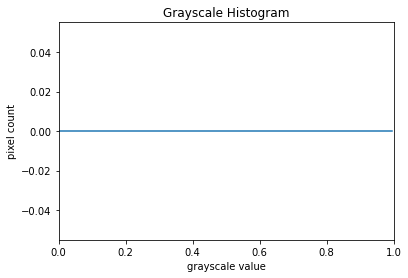

In [22]:
# select pixels of injury mask
injury_mask = injures["label"][3, :, :, :]
values = injures["image"][0, :, :, :][injury_mask == 1]
histogram, bin_edges = np.histogram(values, bins=256, range=(0, 1))

# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()


In [415]:
# val_transforms_synthetic_spleen = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         # RemoveDicts(keys=["image", "label"]),
#         # AddChanneld(keys=["image"]),
#         # AsChannelFirstd(keys=["label"]),
#         # NNUnetScaleIntensity(keys=["image"]),
#         # ToTensord(keys=["image", "label"]),
#         # CreateSyntheticLabel(keys=["label"], threshold=0.5),
#         # Resized(keys=["image", "label"], spatial_size=(259, 259, 259))
#         # WriteToMHA(
#         #     keys=["label"],
#         #     output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays",
#         # ),
#     ]
# )

# final_result = val_transforms_synthetic_spleen([{"image": path_img, "label": path_synth_label }])

In [3]:
from SimpleITK import GetArrayFromImage, ReadImage

HOME = "U:\\"
path_synth_label = os.path.join(HOME, "lauraalvarez", "data","synthetic_overlays","M110074.mha")
path_img = os.path.join(HOME, "lauraalvarez", "data","spleen","imagesTs", "M110040.mha")
path_label = os.path.join(HOME, "lauraalvarez", "data","_overlays_from_alessa","overlay_june9_v2", "overlay", "M110040.mha") 

In [ ]:
# "U:\lauraalvarez\data\_overlays_from_alessa\overlay_june9_v2\overlay\M110040.mha"
# "U:\lauraalvarez\data\_original_full_dataset\mask\M110074.mha"

# data = {"image": ReadImage(path_img) , "label": ReadImage(path_label)}

# data["image"] = sitk.DICOMOrient(data["image"], 'LAS')
# data["label"] = sitk.DICOMOrient(data["label"], 'RAS')

# # data["image"].GetDirection(), data["label"].GetDirection()

# data = {"image": GetArrayFromImage(data["image"]) , "label": GetArrayFromImage(data["label"])}

# print(data["label"].shape , data["image"].shape)

In [50]:
data = {"image": path_img , "label_0": path_label, "label": path_label}

val_transforms_synthetic_spleen = Compose(
    [
        LoadImaged(keys=["image", "label_0", "label"]),
        # RemoveDicts(keys=["image", "label"]),
        AsChannelFirstd(keys=["label_0", "label"]),
        AddChanneld(keys=["image",  "label_0", "label"]),
        ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-175,
                    a_max=250,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
        CreateSyntheticLabel(keys=[ "label"], threshold=0.73),
        ToTensord(keys=["image",  "label_0", "label"]),
        # Resized(keys=["image", "label"], spatial_size=(259, 259, 259))
        # WriteToMHA(
        #     keys=["label"],
        #     output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays",
        # ),
    ]
)

final_result = val_transforms_synthetic_spleen([data])

print(final_result[0]["image"].shape, final_result[0]["label_0"].shape, final_result[0]["label"].shape)

(1, 6, 512, 512, 1441)


RuntimeError: applying transform <__main__.CreateSyntheticLabel object at 0x0000029160E78520>

In [ ]:
image = final_result[0]["image"].numpy()
old_spleen_label = final_result[0]["label_0"][0] # [:,:,3,:,:]
spleen_label =  final_result[0]["label"][0] 

print("shape", image.shape, spleen_label.shape)

post_pred_blending = Compose([AsDiscrete(argmax=True)])
injures_one_channel = post_pred_blending(spleen_label)
old_injures_one_channel =  post_pred_blending(old_spleen_label)

print(f"shape after argmax label {old_injures_one_channel.shape}, {injures_one_channel.shape}, {image.shape}")

blended_label_in = blend_images( image, injures_one_channel.numpy(), 0.5)
blended_label_in_0 = blend_images( image, old_injures_one_channel.numpy(), 0.5)
blended_final = torch.from_numpy(blended_label_in).permute(1, 2, 0, 3)
blended_final_0 = torch.from_numpy(blended_label_in_0).permute(1, 2, 0, 3)

# blended_true_label = blend_images(final_result[0]["image"], old , 0.5)
# blended_true_label = torch.from_numpy(blended_true_label).permute(1, 2, 0, 3)

print("shape after blend", blended_final_0.shape, blended_label_in.shape, blended_final.shape)

shape (1, 512, 512, 1441) torch.Size([6, 512, 512, 1441])
shape after argmax label (1, 512, 512, 1441), (1, 512, 512, 1441), (1, 512, 512, 1441)
shape after blend torch.Size([512, 512, 3, 1441]) (3, 512, 512, 1441) torch.Size([512, 512, 3, 1441])


In [27]:
# spleen_I_label = LabelToContour()(final_result[0]["label"][:,:,3,:,:])
# spleen_O_label =  LabelToContour()(final_result[0]["label"][:,:,1,:,:])
# spleen_label = torch.stack((spleen_O_label.flip(2), spleen_I_label.flip(2))).permute(1,2,0,3,4)
# old = final_result[0]["old_label"][:,:,3,:,:]

labels = [1,3]
channels = list()
for i, channel in enumerate(labels):
    c = LabelToContour()(final_result[0]["label"][:,:, channel, :, :].flip(2))
    c = np.where((c == 1), i + 1, c)
    channels.append(c)

# we got channels splitted with 1 each. if we add them we should get what we want
chans = np.stack(channels, axis=0)
spleen_label = np.max(chans, axis=0)
spleen_label = torch.from_numpy(spleen_label)

spleen_label = (final_result[0]["label"][:,:,1,:,:]).flip(2)
final_result[0]["image"].numpy().shape,  spleen_label.permute(0,1,3,2).numpy().shape

((1, 512, 512, 1441), (1, 6, 1441, 512))

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

def dicom_animation(slice):
    f, axarr = plt.subplots(1, 3, figsize=(30, 30))
    plt.title(f"liver no injured ")
    axarr[0].imshow(image[0, :, :, slice], cmap="bone")
    # axarr[1].imshow(data["image"][0, :, :, slice], cmap="bone")
    axarr[1].imshow(blended_final_0[:, :, :, slice],  cmap="bone")
    axarr[2].imshow(blended_final[:, :, :, slice],  cmap="bone")
    # axarr[1].imshow(injures["label"][1, :, :, slice], cmap="bone")


interact(dicom_animation, slice=(0, blended_final.shape[-1] - 1))


interactive(children=(IntSlider(value=720, description='slice', max=1440), Output()), _dom_classes=('widget-in…

<function __main__.dicom_animation(slice)>

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

def dicom_animation(slice):
    f, axarr = plt.subplots(1, 3, figsize=(30, 30))
    plt.title(f"liver no injured ")
    axarr[0].imshow(image[0, :, :, slice], cmap="bone")
    # axarr[1].imshow(data["image"][0, :, :, slice], cmap="bone")
    axarr[1].imshow(blended_final_0[:, :, :, slice],  cmap="bone")
    axarr[2].imshow(blended_final[:, :, :, slice],  cmap="bone")
    # axarr[1].imshow(injures["label"][1, :, :, slice], cmap="bone")


interact(dicom_animation, slice=(0, blended_final.shape[-1] - 1))

interactive(children=(IntSlider(value=720, description='slice', max=1440), Output()), _dom_classes=('widget-in…

<function __main__.dicom_animation(slice)>

### AQUI

In [2]:
import glob
OUT_FOLDER = "out"
GIF_FOLDER = "super_new_post_gifs_fixed"
ORGAN = "Spleen"
task_name = "Task511_SpleenTraumaCV" # "U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV" Task510_LiverTraumaDGX
images = glob.glob(
    os.path.join(
        "U:\\", #"/mnt", "chansey",# "U:\\",
        "lauraalvarez",
        "nnunet",
        "nnUNet_raw_data",
        task_name,
        "imagesTs",
        "*.nii.gz",
    )
)
predicitions = glob.glob(
    os.path.join(
        "U:\\", # "/mnt", "chansey",# "U:\\",
        "lauraalvarez",
        "nnunet",
        "nnUNet_raw_data",
        task_name,
        OUT_FOLDER,
        "*.nii.gz",
    )
)
true_labels = glob.glob(
    os.path.join(
        "U:\\", #"/mnt", "chansey",# "U:\\",
        "lauraalvarez",
        "nnunet",
        "nnUNet_raw_data",
        task_name,
        "labelsTs",
        "*.nii.gz",
    )
)

data_dicts_test = [
    {"image": image_name, "label": label_name, "tLabel": true_name}
    for image_name, label_name, true_name in zip(images, predicitions, true_labels)
]
task_name = "Task510_LiverTraumaDGX" # "U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV" Task510_LiverTraumaDGX

images = glob.glob(
    os.path.join(
        "U:\\", #"/mnt", "chansey",# "U:\\",
        "lauraalvarez",
        "nnunet",
        "nnUNet_raw_data",
        task_name,
        "imagesTs",
        "*.nii.gz",
    )
)
predicitions = glob.glob(
    os.path.join(
        "U:\\", # "/mnt", "chansey",# "U:\\",
        "lauraalvarez",
        "nnunet",
        "nnUNet_raw_data",
        task_name,
        OUT_FOLDER,
        "*.nii.gz",
    )
)
true_labels = glob.glob(
    os.path.join(
        "U:\\", #"/mnt", "chansey",# "U:\\",
        "lauraalvarez",
        "nnunet",
        "nnUNet_raw_data",
        task_name,
        "labelsTs",
        "*.nii.gz",
    )
)

data_dicts_test_2 = [
    {"image": image_name, "label": label_name, "tLabel": true_name}
    for image_name, label_name, true_name in zip(images, predicitions, true_labels)
]

data_dicts_test = data_dicts_test + data_dicts_test_2

csv_list = []
for data in data_dicts_test[6:]:
    print(f"Infering for image:{data['image']}, label: {data['label']}, true label: {data['tLabel']}")

Infering for image:U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\imagesTs\TRMSPL_000_0000.nii.gz, label: U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\out\TRMSPL_000.nii.gz, true label: U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\labelsTs\TRMSPL_000.nii.gz
Infering for image:U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\imagesTs\TRMSPL_001_0000.nii.gz, label: U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\out\TRMSPL_001.nii.gz, true label: U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\labelsTs\TRMSPL_001.nii.gz
Infering for image:U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\imagesTs\TRMSPL_002_0000.nii.gz, label: U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\out\TRMSPL_002.nii.gz, true label: U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaCV\labelsTs\TRMSPL_002.nii.gz
Infering for image:U:\lauraalvarez\nnunet\nnUNet_raw_data\Task511_SpleenTraumaC

In [116]:
from SimpleITK import GetArrayFromImage, ReadImage
from monai.transforms import EnsureType, EnsureTyped, KeepLargestConnectedComponentd, RemoveSmallObjectsd

HOME = "U:\\"
val_transforms_synthetic_spleen = Compose(
            [
                LoadImaged(keys=["image", "label", "tLabel"]),
                AsChannelFirstd(keys=["image", "label", "tLabel"]),
                AddChanneld(keys=["label", "image", "tLabel"]),
                CropForegroundd(keys=["image", "label", 'tLabel'], source_key="image"),
                Orientationd(keys=["image", "label", 'tLabel'], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-150,
                    a_max=250,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                    
                ),
                # RemoveSmallObjectsd(keys=["label"], min_size=5000, connectivity=None, independent_channels=True),
                KeepLargestConnectedComponentd(keys=["label"], applied_labels=[1,2], is_onehot=False, independent=False, connectivity=None),
                # DilationLabel(keys=["label"]),
                EnsureTyped(keys=["label", "image", "tLabel"], data_type='tensor')
                # ActiveContour(keys=["label", "image"]),
                # FillHolesd(keys=["label"]),
                
            ]
        )

case_number = "6:"
# print("Loading case: ", data_dicts_test[6:]["image"])
injures = val_transforms_synthetic_spleen(data_dicts_test[14:])
# print(injures[0]["image"].shape, injures[0]["label"].shape, injures[0]["tLabel"].shape)

<class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [106]:
from scipy import ndimage
import  skimage.measure as measure

def get_connected_components(init_label, selected_label, min_size=4000):
    result = {}
    removed = {}
    init_label_ = init_label.copy()
    foreground = np.where((init_label_ != selected_label), 0, init_label_)
    labelling, label_count = measure.label(foreground == selected_label, return_num=True)
    init_clusters = np.unique(labelling, return_counts=True)
    for n in range(1, label_count+1):
        cluster_size = ndimage.sum(labelling ==n)
        if cluster_size < min_size:
            labelling[labelling == n] = 0
            removed[n] = cluster_size
        else:
            result[n] = cluster_size
    for n in range(1, label_count+1):
        if n in result.keys():
            labelling[labelling == n] = 2
    
    return labelling, init_clusters, result, removed

# d = dict(injures[i])
# labelling, init_clusters, result, removed = get_connected_components(init_label=d["label"].numpy().astype(np.int8), selected_label=2, min_size=7000)

In [183]:
type(old_true_mask_injury)

numpy.ndarray

In [178]:
settings = {"iterations": 2, "smoothing": 2, "balloon": 0, "threshold": 'auto', 'sigma':2, 'alpha': 7000} #spleen sigma 3

def store_evolution_in(lst):
    def _store(x):
        lst.append(np.copy(x))
    return _store

names = [os.path.basename(i["image"]) for i in data_dicts_test[14:] if os.path.basename(i["image"])]

dice_init = []
dice_final = []
dice_evolution = []
gimages = []
scanners = []
evolutions = []
blended_old_masks = []
blended_true_masks = []
blended_finals = []

for i in range(len(injures)): #len(injures)
    # i = 2
    if i == 5:
        continue
    d = dict(injures[i])
    original_label = d["label"].squeeze() #antes img
    old_old_mask_organ = np.where((original_label != 1), 0, original_label)
    cropped_injury = CropForegroundd(keys=["image", "label", "tLabel"],  source_key="label",  margin=5)(d)
    init_label = cropped_injury["label"].squeeze() #antes img
    old_old_mask_injury = np.where((init_label != 2), 0, init_label) # save only the injury
    old_mask_injury, init_clusters, result, removed = get_connected_components(init_label=old_old_mask_injury.astype(np.int8), selected_label=2, min_size=7000) #liver 7000
    print(old_old_mask_injury.shape, old_mask_injury.shape)
    init_label_true = cropped_injury["tLabel"].squeeze() #antes img
    old_true_mask_injury = np.where((init_label_true != 2), 0, init_label_true) 
    scanner = cropped_injury["image"].squeeze()
    scanners.append(scanner)
    old_mask_organ = np.where((init_label != 1), 0, init_label)
    gimage = inverse_gaussian_gradient(scanner, sigma=settings['sigma'], alpha=settings['alpha']) #init sigma 3 a=100
    gimages.append(gimage)

    evolution = [] 
    callback = store_evolution_in(evolution)
    ls = old_mask_injury
    injury_size = np.sum(old_mask_injury)/2
    print(names[i], injury_size)
    print(result, removed)
    size = 0
    footprint = None
    if injury_size < 25000: #spleen 5000
        dilation_bool= True
        footprint = cube(2) #spleen 8
        size = 2 # 3 spleen
    else: 
        dilation_bool= True
        footprint = ball(1) # 1 para spleen 
        size = 1
    if size != 0: ls = expand_labels(ls, size) #footprint=cube(2)) expand_labels(ls, 2)
    ls = closing(ls)
    ls = morphological_geodesic_active_contour(gimage, num_iter=settings['iterations'],  init_level_set=ls, smoothing=settings['smoothing'], balloon=settings['balloon'],  threshold=settings['threshold'], iter_callback=callback) #morphological_chan_vese
    if dilation_bool: ls = dilation(ls, footprint) 

    evolution = [np.where((item != 1), 0, 2) for item in evolution]
    blended_evolution =  [torch.tensor(blend_images(np.expand_dims(scanner,0), np.expand_dims(item,0), 0.5)).permute(2,1,3,0) for item in evolution]
    evolutions.append(blended_evolution)
    blended_old_mask = torch.tensor(blend_images(np.expand_dims(scanner,0), np.expand_dims(old_old_mask_injury,0), 0.5)).permute(2,1,3,0)
    blended_old_masks.append(blended_old_mask)
    blended_old__true_mask = torch.tensor(blend_images(np.expand_dims(scanner,0), np.expand_dims(old_true_mask_injury,0), 0.5)).permute(2,1,3,0)
    blended_true_masks.append(blended_old__true_mask)
    ls = np.where((ls != 1), 0, 2) 
    blended_final = torch.tensor(blend_images(np.expand_dims(scanner,0), np.expand_dims(ls,0), 0.5)).permute(2,1,3,0)
    blended_finals.append(blended_final)

    from monai.data import MetaTensor
    cropped_injury["label"] = MetaTensor(torch.tensor(np.expand_dims(ls,0)), meta=cropped_injury["label"].meta, applied_operations = cropped_injury["label"].applied_operations )
    inv_cropped = CropForegroundd(keys=["image", "label"], source_key="label",  margin=30).inverse(cropped_injury)
    final_mask_injury = torch.where(((inv_cropped["label"][0]) == 1), 2, 0)
    final_mask = old_old_mask_organ + final_mask_injury
    final_mask = np.where((final_mask == 3), 2, final_mask)
    d["label"] =  np.expand_dims(final_mask,0)

    from sklearn.metrics import jaccard_score
    init_dice = np.round(np.sum(old_old_mask_injury[old_true_mask_injury==2])*2.0 / (np.sum(old_old_mask_injury) + np.sum(old_true_mask_injury)),2)
    jaccard = jaccard_score(old_old_mask_injury, old_true_mask_injury)
    dice_init.append(init_dice)
    dice_scores_evol = [np.round(np.sum(seg[old_true_mask_injury==2])*2.0 / (np.sum(seg) + np.sum(old_true_mask_injury)),2) for seg in evolution]
    dice_evolution.append(dice_scores_evol)
    final_dice = np.round(np.sum(ls[old_true_mask_injury==2])*2.0 / (np.sum(ls) + np.sum(old_true_mask_injury)),2)
    dice_final.append(final_dice)
    
    # break

(410, 246, 193) (410, 246, 193)
TLIV_000_0000.nii.gz 1214314.0
{1: 1214314} {2: 1704, 3: 2}
(276, 326, 289) (276, 326, 289)
TLIV_001_0000.nii.gz 790235.0
{1: 790235} {}
(396, 238, 216) (396, 238, 216)
TLIV_002_0000.nii.gz 8899.0
{5: 8899} {1: 3881, 2: 785, 3: 89, 4: 3738, 6: 637, 7: 2, 8: 6664}
(336, 285, 246) (336, 285, 246)
TLIV_003_0000.nii.gz 351082.0
{1: 351082} {2: 61}
(381, 295, 184) (381, 295, 184)
TLIV_004_0000.nii.gz 40466.0
{1: 40466} {2: 13}
(359, 244, 206) (359, 244, 206)
TLIV_006_0000.nii.gz 39738.0
{6: 39738} {1: 4, 2: 2, 3: 40, 4: 21, 5: 2, 7: 6723, 8: 181, 9: 4707}
(453, 128, 402) (453, 128, 402)
TLIV_007_0000.nii.gz 122192.0
{2: 97816, 5: 10051, 10: 14325} {1: 4676, 3: 492, 4: 6024, 6: 4096, 7: 1, 8: 1136, 9: 3524, 11: 2, 12: 2453, 13: 2, 14: 647, 15: 7, 16: 1, 17: 2, 18: 11, 19: 1, 20: 87, 21: 2695, 22: 128}
(319, 277, 252) (319, 277, 252)
TLIV_008_0000.nii.gz 723755.0
{3: 723755} {1: 776, 2: 249, 4: 1922}


In [142]:
# post_plotting = Compose([DilationLabel(keys=["label"]),])
# post_pro = post_plotting(injures)

post_pro = d.copy()
post_plotting = Compose([AsDiscrete(argmax=False), EnsureType(data_type='tensor')])
post_pro["label"] = post_plotting(post_pro["label"])
inj = dict(post_pro)
inj = Resized(keys=["image", "label", "tLabel"], spatial_size=(512, 512, 512))(inj)
blended_label_in = blend_images(inj["image"], inj["label"], 0.5)
blended_final = blended_label_in.permute(1, 2, 0, 3)
blended_true_label = blend_images(inj["image"], inj["tLabel"], 0.5).numpy()
blended_true_label = torch.from_numpy(blended_true_label).permute(1, 2, 0, 3)

volume = torch.hstack(
    (
        inj["image"].permute(1, 2, 0, 3).repeat(1, 1, 3, 1),
        blended_final,
        blended_true_label,
    )
)
volume = volume.permute(0, 1, 3, 2)
volume.shape

KeyboardInterrupt: 

In [172]:
names = [os.path.basename(i["image"]) for i in data_dicts_test[14:] if os.path.basename(i["image"]) != "TLIV_005_0000.nii.gz"]
dice_liver_i = []
dice_liver_f = []
for name, dice_i, dice_e, dice_f in zip(names[:], dice_init, dice_evolution, dice_final):
    if name.split("_")[0] != 'TRMSPL':
        print(f"{name} - init: {dice_i} - final: {dice_f}")
        print(dice_e)
        dice_liver_i.append(dice_i)
        dice_liver_f.append(dice_f)

print(np.round(np.sum(dice_liver_i)/7, 3), np.round(np.sum(dice_liver_f)/7,3))

TLIV_000_0000.nii.gz - init: 0.81 - final: 0.84
[0.83, 0.83, 0.83]
TLIV_001_0000.nii.gz - init: 0.83 - final: 0.84
[0.84, 0.84, 0.84]
TLIV_002_0000.nii.gz - init: 0.37 - final: 0.68
[0.69, 0.67, 0.64]
TLIV_003_0000.nii.gz - init: 0.67 - final: 0.71
[0.7, 0.69, 0.68]
TLIV_004_0000.nii.gz - init: 0.81 - final: 0.79
[0.8, 0.8, 0.79]
TLIV_006_0000.nii.gz - init: 0.68 - final: 0.78
[0.77, 0.78, 0.78]
TLIV_007_0000.nii.gz - init: 0.46 - final: 0.47
[0.47, 0.47, 0.47]
TLIV_008_0000.nii.gz - init: 0.88 - final: 0.89
[0.89, 0.89, 0.89]
0.787 0.857


In [177]:
names = [os.path.basename(i["image"]) for i in data_dicts_test[14:] if os.path.basename(i["image"]) != "TLIV_005_0000.nii.gz"]
dice_liver_i = []
dice_liver_f = []
for name, dice_i, dice_e, dice_f in zip(names[:], dice_init, dice_evolution, dice_final):
    if name.split("_")[0] != 'TRMSPL':
        print(f"{name} - init: {dice_i} - final: {dice_f}")
        print(dice_e)
        dice_liver_i.append(dice_i)
        dice_liver_f.append(dice_f)

print(np.round(np.sum(dice_liver_i)/7, 3), np.round(np.sum(dice_liver_f)/7,3))

TLIV_000_0000.nii.gz - init: 0.81 - final: 0.82
[0.83, 0.83, 0.83, 0.82, 0.82, 0.81]
TLIV_001_0000.nii.gz - init: 0.83 - final: 0.83
[0.84, 0.84, 0.84, 0.84, 0.83, 0.83]
TLIV_002_0000.nii.gz - init: 0.37 - final: 0.42
[0.69, 0.66, 0.61, 0.53, 0.43, 0.34]
TLIV_003_0000.nii.gz - init: 0.67 - final: 0.67
[0.7, 0.69, 0.67, 0.66, 0.64, 0.63]
TLIV_004_0000.nii.gz - init: 0.81 - final: 0.73
[0.8, 0.8, 0.79, 0.76, 0.73, 0.7]
TLIV_006_0000.nii.gz - init: 0.68 - final: 0.78
[0.77, 0.79, 0.79, 0.77, 0.76, 0.75]
TLIV_007_0000.nii.gz - init: 0.46 - final: 0.44
[0.47, 0.47, 0.46, 0.44, 0.42, 0.41]
TLIV_008_0000.nii.gz - init: 0.88 - final: 0.87
[0.89, 0.89, 0.89, 0.88, 0.87, 0.86]
0.787 0.794


In [484]:
dice_spleen_i = []
dice_spleen_f = []
for name, dice_i, dice_e, dice_f in zip(names, dice_init, dice_evolution, dice_final):
    if name.split("_")[0] == 'TRMSPL':
        print(f"{name} - init: {dice_i} - final: {dice_f}")
        print(dice_e)
        dice_spleen_i.append(dice_i)
        dice_spleen_f.append(dice_f)

print(np.round(np.sum(dice_spleen_i)/7, 3), np.round(np.sum(dice_spleen_f)/7,3))

0.0 0.0


In [ ]:
gimages
scanners
evolutions = []
blended_old_masks = []
blended_true_masks = []
blended_finals = []

In [175]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

a, b, c, d, e = 0, 1, 2, 2, 2
a = 0
b = 2
i = 5
def dicom_animation(slice= slice, i=i):
    f, axarr = plt.subplots(1, 7, figsize=(30, 20))
    axarr[0].imshow(gimages[i][slice, :, :], cmap="bone")
    axarr[1].imshow(scanners[i][slice, :, :], cmap="bone")
    axarr[2].imshow(blended_true_masks[i][:, slice, :,:])
    axarr[3].imshow(blended_old_masks[i][:, slice, :,:])
    axarr[4].imshow(evolutions[i][a][:, slice, :,:])
    axarr[5].imshow(evolutions[i][b][:, slice, :,:])
    # axarr[6].imshow(blended_evolution[c][:, slice, :,:])
    # axarr[7].imshow(blended_evolution[d][:, slice, :,:])
    axarr[6].imshow(blended_finals[i][:, slice, :,:])
    axarr[0].set_title("Gaussian Gradient")
    axarr[1].set_title("Scanner")
    axarr[2].set_title("Ground Truth")
    axarr[3].set_title(f"Init {dice_init[i]}")
    axarr[4].set_title("Remove small components {}".format( dice_evolution[i][a]))
    axarr[5].set_title("Active contours {}, {}".format(b, dice_evolution[i][b]))
    # axarr[6].set_title("Evolution {}, {}".format(c, dice_scores_evol[c]))
    # axarr[7].set_title("Evolution {}, {}".format(d, dice_scores_evol[d]))
    axarr[6].set_title("Expand labels {}".format(dice_final[i]))
    for i in range(7):
        axarr[i].set_axis_off()
        axarr[i].invert_xaxis()
    # print(os.path.basename(data_dicts_test[case_number]["image"]))
    # print("{settings}".format(settings=settings))
interact(dicom_animation, slice=(0,scanners[i].shape[0] - 1), i=(0, len(scanners)-1))

interactive(children=(IntSlider(value=179, description='slice', max=358), IntSlider(value=5, description='i', …

<function __main__.dicom_animation(slice=<class 'slice'>, i=5)>

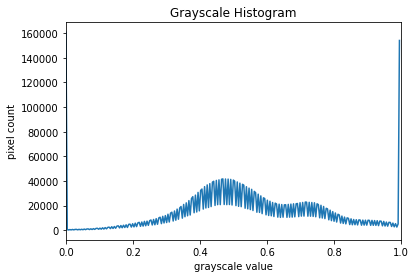

In [147]:
histogram, bin_edges = np.histogram(scanner, bins=256, range=(0, 1))
# plot histogram
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here

In [193]:
a, b, c, d, e = 0, 1, 2, 2, 2
a = 0
b = 2
i = 5
def dicom_animation(slice= slice, i=i):
    f, axarr = plt.subplots(1, 7, figsize=(15, 20))
    axarr[0].imshow(np.swapaxes(gimages[i][slice, :, :], 1, 0), cmap="bone")
    axarr[1].imshow(np.swapaxes(scanners[i][slice, :, :], 1, 0), cmap="bone")
    axarr[2].imshow(np.swapaxes(blended_true_masks[i][:, slice, :,:], 1, 0))
    axarr[3].imshow(np.swapaxes(blended_old_masks[i][:, slice, :,:], 1, 0))
    axarr[4].imshow(np.swapaxes(evolutions[i][a][:, slice, :,:], 1, 0))
    axarr[5].imshow(np.swapaxes(evolutions[i][b][:, slice, :,:], 1, 0))
    # axarr[6].imshow(blended_evolution[c][:, slice, :,:])
    # axarr[7].imshow(blended_evolution[d][:, slice, :,:])
    axarr[6].imshow(np.swapaxes(blended_finals[i][:, slice, :,:], 1, 0))
    axarr[0].set_title("Gaussian Gradient")
    axarr[1].set_title("Scanner")
    axarr[2].set_title("Ground Truth")
    axarr[3].set_title(f"Init {dice_init[i]}")
    axarr[4].set_title("Remove small components {}".format( dice_evolution[i][a]))
    axarr[5].set_title("Active contours {}, {}".format(b, dice_evolution[i][b]))
    # axarr[6].set_title("Evolution {}, {}".format(c, dice_scores_evol[c]))
    # axarr[7].set_title("Evolution {}, {}".format(d, dice_scores_evol[d]))
    axarr[6].set_title("Expand labels {}".format(dice_final[i]))
    for i in range(7):
        axarr[i].set_axis_off()
        axarr[i].invert_xaxis()
    # print(os.path.basename(data_dicts_test[case_number]["image"]))
    # print("{settings}".format(settings=settings))
interact(dicom_animation, slice=(0,scanners[i].shape[0] - 1), i=(0, len(scanners)-1))

interactive(children=(IntSlider(value=179, description='slice', max=358), IntSlider(value=5, description='i', …

<function __main__.dicom_animation(slice=<class 'slice'>, i=5)>